In [1]:
from __future__ import annotations
try:
    from mediocreatbest import auto
except ImportError:
    %pip install --user --upgrade pip
    %pip install --user --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df
    from mediocreatbest import auto


In [2]:
!nvidia-smi | grep Quadro
!./go.sh gs configure
!./go.sh gs build


|   0  Quadro M6000 24GB   Off  | 00000000:82:00.0 Off |                  Off |
-- Configuring done
-- Generating done
-- Build files have been written to: /home/thobson2/src/GraphShaders/build
-- Cache values
CMAKE_BUILD_TYPE:STRING=Debug
CMAKE_INSTALL_PREFIX:PATH=/home/thobson2/src/GraphShaders/stage
/usr/bin/cmake -S/home/thobson2/src/GraphShaders -B/home/thobson2/src/GraphShaders/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /home/thobson2/src/GraphShaders/build/CMakeFiles /home/thobson2/src/GraphShaders/build/CMakeFiles/progress.marks
/usr/bin/make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/home/thobson2/src/GraphShaders/build'
/usr/bin/make -f CMakeFiles/graphshader.dir/build.make CMakeFiles/graphshader.dir/depend
make[2]: Entering directory '/home/thobson2/src/GraphShaders/build'
cd /home/thobson2/src/GraphShaders/build && /usr/bin/cmake -E cmake_depends "Unix Makefiles" /home/thobson2/src/GraphShaders /home/thobson2

In [3]:
auto.sys.path.append(str(auto.pathlib.Path.cwd() / 'src'))
import graphshader
gs = auto.graphshader.GS.load(str(auto.pathlib.Path.cwd() / 'build' / 'libgraphshader.so'))


In [4]:
def Transpile(code: str, /, *, files: dict[str, auto.os.PathLike]) -> dict[str, str]:
    with auto.tempfile.TemporaryDirectory() as tempdir:
        tempdir = auto.pathlib.Path(tempdir)
        
        printenv0 = tempdir / 'printenv0'
        printenv0.write_text('#!/usr/bin/env sh\nexec printenv -0')
        printenv0.chmod(0o500)
        
        inpfile = tempdir / 'inpfile'
        inpfile.write_text(code)
        
        args = [
            auto.sys.executable,
            'src/GraphShaderTranspiler.py',
        ] + sum([
            ['-f', str(k), str(v)]
            for k, v in files.items()
        ], []) + [
            '-i', str(inpfile),
            '-x', str(printenv0),
        ]
        
        stdout = auto.subprocess.check_output(args)
        env = {}
        for line in stdout.split(b'\0'):
            line = line.decode('ascii')
            if line == '':
                continue
            
            try:
                k, v = line.split('=', 1)
            except ValueError:
                print(f'{line=!r}')
                raise
                
            env[k] = v
        
        return env


EGL_VERSION: 1.5
EGL_VENDOR: NVIDIA
EGL_CLIENT_APIS: OpenGL_ES OpenGL
EGL_EXTENSIONS: EGL_EXT_buffer_age EGL_EXT_client_sync EGL_EXT_create_context_robustness EGL_EXT_image_dma_buf_import EGL_EXT_image_dma_buf_import_modifiers EGL_MESA_image_dma_buf_export EGL_EXT_output_base EGL_EXT_protected_content EGL_EXT_stream_acquire_mode EGL_EXT_sync_reuse EGL_IMG_context_priority EGL_KHR_config_attribs EGL_KHR_create_context_no_error EGL_KHR_context_flush_control EGL_KHR_create_context EGL_KHR_fence_sync EGL_KHR_get_all_proc_addresses EGL_KHR_partial_update EGL_KHR_swap_buffers_with_damage EGL_KHR_no_config_context EGL_KHR_gl_colorspace EGL_KHR_gl_renderbuffer_image EGL_KHR_gl_texture_2D_image EGL_KHR_gl_texture_3D_image EGL_KHR_gl_texture_cubemap_image EGL_KHR_image EGL_KHR_image_base EGL_KHR_reusable_sync EGL_KHR_stream EGL_KHR_stream_attrib EGL_KHR_stream_consumer_gltexture EGL_KHR_stream_cross_process_fd EGL_KHR_stream_fifo EGL_KHR_stream_producer_eglsurface EGL_KHR_surfaceless_context EGL

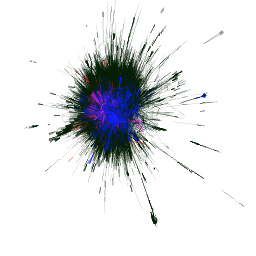

In [7]:
%%scope

env = Transpile(
    auto.pathlib.Path('examples/JS-Deps/JS-Deps.gsp').read_text(),
    files=dict(
        element="examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
        X      ="examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
        Y      ="examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
        Date   ="examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
        Devs   ="examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
        Vuln   ="examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
    ),
)

with auto.contextlib.ExitStack() as stack:
    enter = stack.enter_context
    
    enter( gs.environment() )
    
    for k, v in env.items():
        gs[k] = v
    
    gs['GS_OUTPUT'] = '<MEMORY>'
    
    enter( gs.egl() )
    enter( gs.gl() )
    enter( gs.data() )
    enter( gs.shader() )
    image = enter( gs.render() )
    
    auto.IPython.display.display(auto.IPython.display.Image(image))
    

In [8]:
%%scope

env = Transpile(
    auto.pathlib.Path('examples/JS-Deps/JS-Deps.gsp').read_text(),
    files=dict(
    ),
)
auto.pprint.pprint({
    k: v
    for k, v in env.items()
    if k.startswith("GS_BUFFER_NAME")
})


{'GS_BUFFER_NAME_0': '_ELEMENT',
 'GS_BUFFER_NAME_1': '_X',
 'GS_BUFFER_NAME_2': '_Y',
 'GS_BUFFER_NAME_3': '_Date',
 'GS_BUFFER_NAME_4': '_Devs',
 'GS_BUFFER_NAME_5': '_Vuln',
 'GS_BUFFER_NAME_6': '_in_degree',
 'GS_BUFFER_NAME_7': '_out_degree',
 'GS_BUFFER_NAME_8': '_Seen',
 'GS_BUFFER_NAME_9': '_ATOMIC'}


EGL_VERSION: 1.5
EGL_VENDOR: NVIDIA
EGL_CLIENT_APIS: OpenGL_ES OpenGL
EGL_EXTENSIONS: EGL_EXT_buffer_age EGL_EXT_client_sync EGL_EXT_create_context_robustness EGL_EXT_image_dma_buf_import EGL_EXT_image_dma_buf_import_modifiers EGL_MESA_image_dma_buf_export EGL_EXT_output_base EGL_EXT_protected_content EGL_EXT_stream_acquire_mode EGL_EXT_sync_reuse EGL_IMG_context_priority EGL_KHR_config_attribs EGL_KHR_create_context_no_error EGL_KHR_context_flush_control EGL_KHR_create_context EGL_KHR_fence_sync EGL_KHR_get_all_proc_addresses EGL_KHR_partial_update EGL_KHR_swap_buffers_with_damage EGL_KHR_no_config_context EGL_KHR_gl_colorspace EGL_KHR_gl_renderbuffer_image EGL_KHR_gl_texture_2D_image EGL_KHR_gl_texture_3D_image EGL_KHR_gl_texture_cubemap_image EGL_KHR_image EGL_KHR_image_base EGL_KHR_reusable_sync EGL_KHR_stream EGL_KHR_stream_attrib EGL_KHR_stream_consumer_gltexture EGL_KHR_stream_cross_process_fd EGL_KHR_stream_fifo EGL_KHR_stream_producer_eglsurface EGL_KHR_surfaceless_context EGL

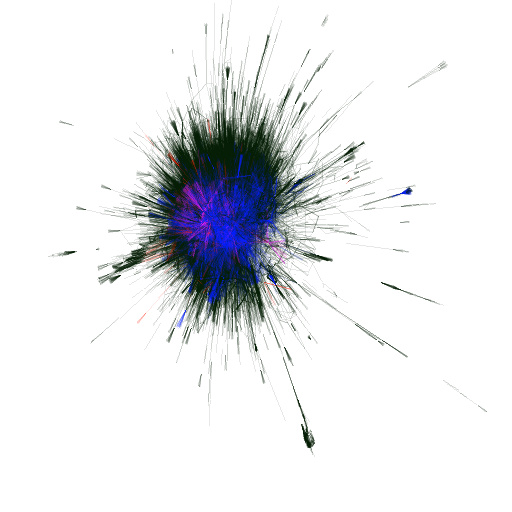

In [9]:
%%scope

env = Transpile(
    auto.pathlib.Path('examples/JS-Deps/JS-Deps.gsp').read_text(),
    files=dict(
    ),
)
# auto.pprint.pprint(env)

def Read(path: auto.os.PathLike, /, *, dtype: auto.np.DType) -> auto.np.ndarray:
    return auto.np.fromfile(path, dtype)

#         element="examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
#         X      ="examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
#         Y      ="examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
#         Date   ="examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
#         Devs   ="examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
#         Vuln   ="examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
element = Read("examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
    dtype=[ ('i', 'u4'), ('j', 'u4') ],
)
x = Read("examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
    dtype=[ ('x', 'f4') ],
)
y = Read("examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
    dtype=[ ('y', 'f4') ],
)
date = Read("examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
    dtype=[ ('date', 'u4') ],
)
devs = Read("examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
    dtype=[ ('devs', 'u4') ],
)
vuln = Read("examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
    dtype=[ ('vuln', 'u4') ],
)
# print(f'{element.ctypes.data=!r}')

with auto.contextlib.ExitStack() as stack:
    enter = stack.enter_context
    
    enter( gs.environment() )
    
    for k, v in env.items():
        gs[k] = v
    
    enter( gs.egl() )
    
    gs['GS_TILE_WIDTH'] = '512'
    gs['GS_TILE_HEIGHT'] = '512'
    enter( gs.gl() )
    
    gs['_ELEMENT'] = element
    gs['_X'] = x
    gs['_Y'] = y
    gs['_Date'] = date
    gs['_Devs'] = devs
    gs['_Vuln'] = vuln
    enter( gs.data() )

    enter( gs.shader() )
    
    gs['GS_OUTPUT'] = '<MEMORY>'
    image = enter( gs.render() )
    auto.IPython.display.display(auto.IPython.display.Image(image))


In [14]:
@auto.dataclasses.dataclass
class Graph:
    files: dict[str, auto.pathlib.Path] = auto.dataclasses.field(default_factory=dict)
    datas: dict[str, auto.np.ndarray] = auto.dataclasses.field(default_factory=dict)
    program: str | None = auto.dataclasses.field(default=None)
    size: tuple[
        auto.typing.Annotated[int, 'width'],
        auto.typing.Annotated[int, 'height'],
    ] = auto.dataclasses.field(default=None)
    tile: tuple[
        auto.typing.Annotated[int, 'zoom'],
        auto.typing.Annotated[int, 'row'],
        auto.typing.Annotated[int, 'col'],
    ] = auto.dataclasses.field(default=None)
    verbose: bool | None = auto.dataclasses.field(default=None)
    
    def render(
        self: Self,
        *,
        program: str | None = None,
        size: tuple[
            auto.typing.Annotated[int, 'width'],
            auto.typing.Annotated[int, 'height'],
        ] | None = None,
        tile: tuple[
            auto.typing.Annotated[int, 'zoom'],
            auto.typing.Annotated[int, 'row'],
            auto.typing.Annotated[int, 'col'],
        ] | None = None,
        temp: auto.pathlib.Path|None=None,
        inpfile: auto.pathlib.Path|None=None,
        outfile: auto.pathlib.Path|None=None,
        verbose: bool | None=None,
    ) -> auto.typing.Annotated[bytes, 'jpeg']:
        if (inpfile is None or outfile is None) and (temp is None):
            with auto.tempfile.TemporaryDirectory(dir=auto.pathlib.Path('tmp')) as temp:
                temp = auto.pathlib.Path(temp)
                return self.render(
                    program=program,
                    size=size,
                    tile=tile,
                    temp=temp,
                    inpfile=inpfile,
                    outfile=outfile,
                    verbose=verbose,
                )
        
        if program is None:
            assert self.program is not None
            program = self.program
        
        if size is None:
            assert self.size is not None
            size = self.size
        
        if tile is None:
            assert self.tile is not None
            tile = self.tile
        
        if verbose is None:
            assert self.verbose is not None
            verbose = self.verbose

        if inpfile is None:
            inpfile = temp / 'inpfile.gsp'

        if outfile is None:
            outfile = temp / 'outfile.jpg'

        inpfile.write_text(program)
        
        args = [
#             './go.sh', 'docker', 'exec',
            './go.sh', 'gs', 'exec',
            'GraphShaderTranspiler.py',
        ] + sum([
            ['-f', str(k), str(v)]
            for k, v in self.files.items()
        ], []) + [
            '-e', 'GS_TILE_WIDTH', str(size[0]),
            '-e', 'GS_TILE_HEIGHT', str(size[1]),
            '-e', 'GS_TILE_Z', str(tile[0]),
            '-e', 'GS_TILE_Y', str(tile[1]),
            '-e', 'GS_TILE_X', str(tile[2]),
            '-i', str(inpfile),
            '-e', 'GS_OUTPUT', str(outfile),
        ]
        
        if verbose:
            print(f'$ {auto.shlex.join(args)}', file=auto.sys.stderr, flush=True)
            
        kwargs = {}
        if not verbose:
            kwargs['stderr'] = auto.subprocess.DEVNULL
            kwargs['stdout'] = auto.subprocess.DEVNULL
        auto.subprocess.check_call(args, **kwargs)
        
        return outfile.read_bytes()


In [15]:
@auto.IPython.core.magic.register_cell_magic('graph.render')
def render(line: str, cell: str, /):
    def render(*, graph: Graph, program: str, verbose: bool):
#         auto.pprint.pprint(dict(line=line, cell=cell, graph=graph, program=program))
        image: bytes = graph.render(
            program=program,
            verbose=verbose,
        )
        auto.IPython.display.display(auto.IPython.display.Image(
            image,
        ))

    parser = auto.argparse.ArgumentParser()
    parser.add_argument('--name', '-n', dest='graph', default='graph')
    parser.add_argument('--verbose', '-v', action='store_true')
    parser.set_defaults(program=cell)
    
    args = auto.shlex.split(line)
    args = vars(parser.parse_args(args))
    
    args['graph'] = get_ipython().ev(args.pop('graph'))
    
    render(**args)


In [16]:
JSDeps = Graph(
    files=dict(
        element="examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin",
        X      ="examples/JS-Deps/data/JS-Deps.node.x.f32.bin",
        Y      ="examples/JS-Deps/data/JS-Deps.node.y.f32.bin",
        Date   ="examples/JS-Deps/data/JS-Deps.node.date.u32.bin",
        Devs   ="examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin",
        Vuln   ="examples/JS-Deps/data/JS-Deps.node.cve.u32.bin",
    ),
    size=(512, 512),
    tile=(0, 0, 0),
    verbose=False,
)


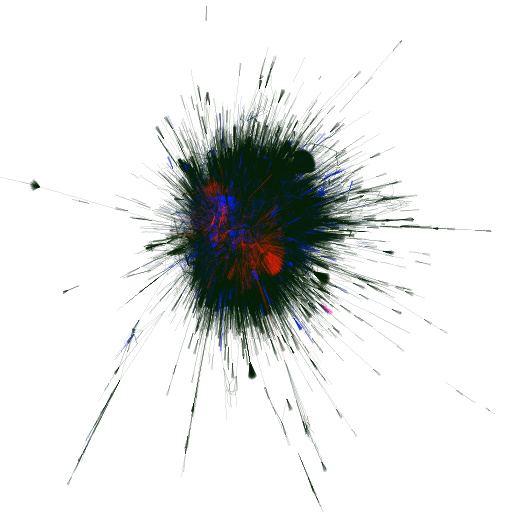

In [17]:
%%graph.render -n JSDeps
#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint Date[N])
#pragma gs attribute(uint Devs[N])
#pragma gs attribute(uint Vuln[N])

#define NOV_09_2010 1289278800
#define MAR_22_2016 1458619200

#define JAN_01_2011 1293858000
#define JAN_01_2012 1325394000
#define JAN_01_2013 1357016400
#define JAN_01_2014 1388552400
#define JAN_01_2015 1420088400
#define JAN_01_2016 1451624400

#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];

    gs_NodePosition = vec3(x, y, 0);
}

#pragma gs shader(relational)
void main() {
}

#pragma gs shader(appearance)
void main() {
    bool d = false;

    #pragma gs define(LO JAN_01_2015)
    #pragma gs define(HI JAN_01_2016)
    d = d || Date[gs_SourceIndex] < LO;
    d = d || Date[gs_SourceIndex] > HI;
    d = d || Date[gs_TargetIndex] < LO;
    d = d || Date[gs_TargetIndex] > HI;
    
    if (d) discard;
    
    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);
    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = float(vuln);
    gs_FragColor.b = float(risky);
}


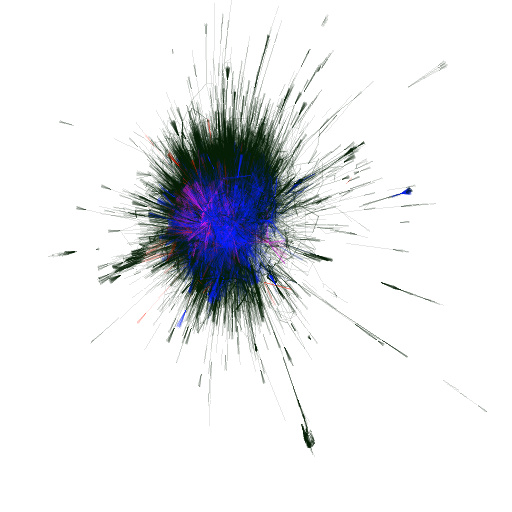

In [19]:
%%graph.render -n JSDeps
// JS-Deps: Node Package Manager Dependency Graph
//
// Nodes are packages. Edges are directed from a package to its dependencies.

#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint Date[N])
#pragma gs attribute(uint Devs[N])
#pragma gs attribute(uint Vuln[N])

#define NOV_09_2010 1289278800
#define MAR_22_2016 1458619200

#define JAN_01_2011 1293858000
#define JAN_01_2012 1325394000
#define JAN_01_2013 1357016400
#define JAN_01_2014 1388552400
#define JAN_01_2015 1420088400
#define JAN_01_2016 1451624400

// Some controls
#pragma gs define(USE_COLOR)
#pragma gs define(USE_FILTER)
#pragma gs define(USE_RELATIONAL)


#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];

    gs_NodePosition = vec3(x, y, 0);
}


#pragma gs shader(relational)
void main() {
    #pragma gs scratch(uint in_degree[N])
    #pragma gs scratch(uint out_degree[N])
    #pragma gs scratch(atomic_uint in_degree_max)
    #pragma gs scratch(atomic_uint out_degree_max)

    #pragma gs define(USE_RELATIONAL 1)
    #if USE_RELATIONAL
    uint od = 1 + atomicAdd(out_degree[gs_SourceIndex], 1);
    atomicCounterMax(out_degree_max, od);

    uint id = 1 + atomicAdd(in_degree[gs_TargetIndex], 1);
    atomicCounterMax(in_degree_max, id);
    #endif /* USE_RELATIONAL */
}


#pragma gs shader(appearance)
void main() {
    #pragma gs scratch(uint Seen[E])
    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);
    bool d = false;

    #pragma gs scratch(atomic_uint total)
    if (first) atomicCounterAdd(total, 1);

    #pragma gs define(FILTER_BY_DATE 1)
    #if FILTER_BY_DATE
    #pragma gs define(LO JAN_01_2014)
    #pragma gs define(HI JAN_01_2015)

    if (Date[gs_SourceIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint source_date_too_lo)
        if (first) atomicCounterAdd(source_date_too_lo, 1);
    }

    if (Date[gs_SourceIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint source_date_too_hi)
        if (first) atomicCounterAdd(source_date_too_hi, 1);
    }

    if (Date[gs_TargetIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint target_date_too_lo)
        if (first) atomicCounterAdd(target_date_too_lo, 1);
    }

    if (Date[gs_TargetIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint target_date_too_hi)
        if (first) atomicCounterAdd(target_date_too_hi, 1);
    }
    #endif /* FILTER_BY_DATE */

    if (d) {
        #pragma gs scratch(atomic_uint discarded)
        if (first) atomicCounterAdd(discarded, 1);
        discard;
    } else {
        #pragma gs scratch(atomic_uint kept)
        if (first) atomicCounterAdd(kept, 1);
    }

    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);
    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];

    #if USE_RELATIONAL
    const uint depends_on_source = in_degree[gs_SourceIndex];
    const uint depends_on_target = in_degree[gs_TargetIndex];

    risky = depends_on_source + depends_on_target > 100 * Devs[gs_TargetIndex];
    #endif /* USE_RELATIONAL */

    if (risky) {
        #pragma gs scratch(atomic_uint total_risky)
        if (first) atomicCounterAdd(total_risky, 1);
    }

    if (risky && vuln) {
        #pragma gs scratch(atomic_uint total_vuln_and_risky)
        if (first) atomicCounterAdd(total_vuln_and_risky, 1);
    }

    if (vuln) {
        #pragma gs scratch(atomic_uint total_vuln)
        if (first) atomicCounterAdd(total_vuln, 1);
    }

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = float(vuln);
    gs_FragColor.b = float(risky);
}
